# Project 2
## Introduction to Deep Learning
Build a Deep Learning model, TensorFlow framework

In [1]:
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install tensorflow
!pip install pyarrow
!pip install openpyxl


## Getting data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statsmodels.api as smg
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# setting up work space
import os

data_directory = "data"
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    print("data directory created successfully!")

pickled_data = "pickled-data"
if not os.path.exists(pickled_data):
    os.makedirs(pickled_data)
    print("pickled_data directory created successfully!")
    
trained_models = "models"
if not os.path.exists(trained_models):
    os.makedirs(trained_models)
    print("trained_models directory created successfully!")

In [3]:
# loading NYC/TLC Yellow Cab dataset
df_trip_data = pd.read_parquet("data/trip-data.parquet")
df_trip_data.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [5]:
df_climate_data = pd.read_excel("data/weather-nyc.xlsx")
df_climate_data.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-01-01,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
1,2020-01-02,4.7,0.6,8.9,NaN,NaN,NaN,12.4,NaN,1013.9,NaN
2,2020-01-03,7.6,6.7,8.3,NaN,NaN,NaN,8.4,NaN,1010.2,NaN
3,2020-01-04,8.2,6.7,9.4,NaN,NaN,NaN,5.7,NaN,1003.7,NaN
4,2020-01-05,4.6,2.8,7.2,NaN,NaN,NaN,8.2,NaN,1010.1,NaN


#### Merging the data sets by creating a common column

In [6]:
# add column date the trip data
new_col = pd.DataFrame({"date": []}).astype('string')
df_trip_data = pd.concat([df_trip_data, new_col], axis=1)

In [7]:

# extract date from pickup and add to new column "date"
for i, row in df_trip_data.iterrows():
    extracted_date = row.tpep_pickup_datetime.strftime("%Y-%m-%d")
    df_trip_data.at[i, "date"] = extracted_date

#### Merged datasets inner merge

In [8]:
# merge the the two datasets dropping the rows with NaN
merged_df = pd.merge(df_trip_data, df_climate_data, on="date", how="inner")
print("Index before merge",df_trip_data.index, "\n index after merge", merged_df.index )

Index before merge RangeIndex(start=0, stop=6405008, step=1) 
 index after merge RangeIndex(start=0, stop=6404796, step=1)


After an inner merge data lost is 212 entries which is about 0.003% therefore insignificant loss

### Quick look at the data structure

In [9]:
merged_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,...,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,...,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,...,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,...,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,...,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN


In [10]:
# summary of each numerical attribute
merged_df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,6.404796e+06,6404796,6404796,6.339355e+06,6.404796e+06,6.339355e+06,6.404796e+06,6.404796e+06,6.404796e+06,6.404796e+06,...,5.798568e+06,5.798568e+06,5.798568e+06,0.0,0.0,228201.0,5.608782e+06,0.0,5.608782e+06,0.0
mean,1.672991e+00,2020-01-17 03:32:36.146985,2020-01-17 03:48:32.832052,1.515318e+00,2.929631e+00,1.059905e+00,1.647327e+02,1.626628e+02,1.257315e+00,1.269404e+01,...,4.165661e+00,1.410972e+00,7.464099e+00,NaN,NaN,265.0,1.061334e+01,NaN,1.021145e+03,NaN
min,1.000000e+00,2020-01-01 00:00:00,2020-01-01 00:01:17,0.000000e+00,-3.062000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.238000e+03,...,-2.200000e+00,-5.000000e+00,2.200000e+00,NaN,NaN,265.0,5.700000e+00,NaN,1.003700e+03,NaN
25%,1.000000e+00,2020-01-09 17:11:18.750000,2020-01-09 17:28:04,1.000000e+00,9.600000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,...,1.300000e+00,-1.700000e+00,5.000000e+00,NaN,NaN,265.0,8.200000e+00,NaN,1.013900e+03,NaN
50%,2.000000e+00,2020-01-16 23:16:49,2020-01-16 23:32:42,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,...,4.600000e+00,1.700000e+00,7.200000e+00,NaN,NaN,265.0,9.900000e+00,NaN,1.020900e+03,NaN
75%,2.000000e+00,2020-01-24 18:24:30,2020-01-24 18:39:51,2.000000e+00,2.930000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.400000e+01,...,6.500000e+00,3.300000e+00,9.400000e+00,NaN,NaN,265.0,1.070000e+01,NaN,1.028500e+03,NaN
max,5.000000e+00,2020-01-31 23:59:59,2020-02-02 09:51:19,9.000000e+00,2.102401e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.265000e+03,...,1.570000e+01,9.400000e+00,1.940000e+01,NaN,NaN,265.0,2.290000e+01,NaN,1.038800e+03,NaN
std,4.691305e-01,NaN,NaN,1.151571e+00,8.316048e+01,8.118468e-01,6.554358e+01,6.991261e+01,4.885656e-01,1.212685e+01,...,3.667097e+00,3.648041e+00,3.544082e+00,NaN,NaN,0.0,3.679739e+00,NaN,9.422310e+00,NaN


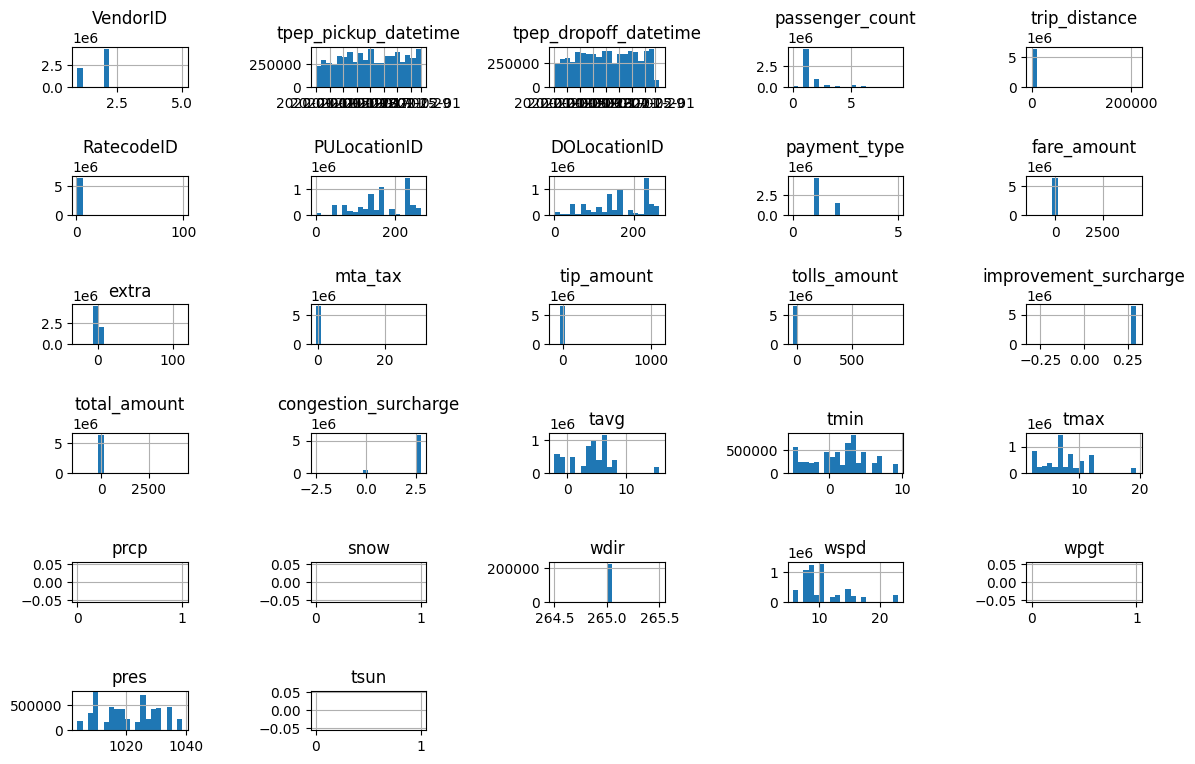

In [11]:
# a histogram showing number of instances vs the value range
merged_df.hist(bins=20, figsize=(12,8))
plt.grid(True)
plt.tight_layout(pad=2)
plt.show()

#### Business objective and framing the problem
From the data frames. It prompts that the training supervision is a supervised learning task. Since each instance comes with the expected output i.e., the expected trip duration.

Since the model is meant to predict duration of trips it is therefore a regression task, specifically multiple regression problem due to the multiple features. It is also a univariate regression problem as we are interested in predicting a single duration per trip.

#### Performance measure
As recommended loss functions; Mean Square Error (MSE) and Mean Absolute Error (MAE)

In [12]:
import datetime

# add trip_duration column
for i, row in merged_df.iterrows():
    duration = datetime.datetime.strptime(str(row.tpep_dropoff_datetime), "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(str(row.tpep_pickup_datetime), "%Y-%m-%d %H:%M:%S")
    merged_df.at[i, "trip_duration"] = duration

In [ ]:
merged_df = pd.to_parquet("data/merged-with-trip-duration")

### Creating a test set 80/20
Because the data generated is time-sensitive we categorize the data into 'night', 'morning', 'afternoon', 'evening' then perform strattified sampling on each category.

In [5]:
merged_df = pd.read_parquet("data/merged-with-trip-duration")

In [6]:
# add pickup_time_category column
merged_df["pickup_time_cat"] = pd.cut(
                pd.to_datetime(merged_df["tpep_pickup_datetime"]).dt.hour,    
                bins=[0, 6, 12, 18, 24],
                labels=['night', 'morning', 'afternoon', 'evening'],
                right=False)

In [8]:
merged_df.to_parquet("data/04merged-with-trip-duration-pickup-cat")
merged_df.head()